In [1]:
import pandas as pd
import numpy as np
import os
import re
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from spacy import prefer_gpu
from spacy import load as spacyload
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER
from spacy.lang.char_classes import CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS, HYPHENS
from spacy.symbols import ORTH
from spacy.util import compile_infix_regex

In [3]:
prefer_gpu()
spacy_size = "md"
spacy_model = "en_core_web_{}".format(spacy_size)
nlp = spacyload(spacy_model)

In [4]:
# https://spacy.io/usage/linguistic-features
infixes = (
    LIST_ELLIPSES
    + LIST_ICONS
    + [
        r"(?<=[0-9])[+\-\*^](?=[0-9-])",
        r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
            al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
        ),
        r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
        # r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
        r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
    ]
)


infix_re = compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer

# avoid tokenizing mask
MASK = "$T$"
special_case = [{ORTH: MASK}]
nlp.tokenizer.add_special_case(MASK, special_case)


In [5]:
path = os.path.join(os.getcwd(), "graphql-topic-downloads", "all_entities.csv")

In [6]:
df = pd.read_csv(path)
df.shape

(50412, 11)

In [7]:
df.drop_duplicates(subset="text", inplace=True)
df.shape

(43706, 11)

In [8]:
# add text length as a column
df['text_length'] = np.nan

def add_text_length(row):
    row['text_length'] = len(row['text'])
    return row
    
df = df.apply(lambda row: add_text_length(row), axis=1)

In [9]:
q_min, q_max = (df['text_length'].dropna().quantile([0.1, 0.9]))
print('keeping text lengths within 80% of the distribution')
print('min: {}, max: {}'.format(q_min, q_max))
shortened_texts = df[(df.text_length > q_min) & (df.text_length < q_max)]

print('Dropping {} rows'.format(df.shape[0] - shortened_texts.shape[0]))
df.shape

keeping text lengths within 80% of the distribution
min: 56.0, max: 258.0
Dropping 8770 rows


(43706, 12)

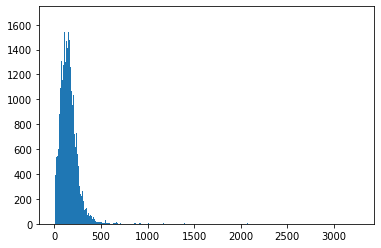

In [10]:
_ = plt.hist(df['text_length'], bins=500)

In [11]:
df = shortened_texts
df.shape

(34936, 12)

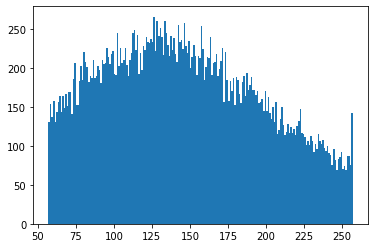

In [12]:
_ = plt.hist(df['text_length'], bins=200)

In [13]:
def erase_newlines(row):
    row['text'] = re.sub(r"(\n+)", " ", row['text'])
    return row

# plenty of newspapers use the proper left/right double quotation marks instead of ", remove.
def erase_quotes(row):
    row['text'] = re.sub(r"([“”])", "", row['text'])
    return row

# remove prefix symbols, such as "???????!" becomes "!" and ".............." becomes "."
# should not be present in these texts, but one might find duplicates in certain newspapers.
def replace_puncts(row):
    row['text'] = re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', row['text'])
    return row

def space_tokens(row):
    try:
        spacydoc = nlp(row['text'])
        tokens = [t.text for t in spacydoc]
        row['text'] = ' '.join(tokens)
    except ValueError:
        print(row)
    return row

# replace brackets by LRB (left round bracket) and RRB, to conform with the format of .xml.seg
def replace_brackets(row):
    row['text'] = re.sub(r"([(])", '-LRB-', row['text'])
    row['text'] = re.sub(r"([)])", '-RRB-', row['text'])
    return row

def neutralize(row):
    score = row['sentiment_score']
    if score < 0.8:
        row['sentiment'] = 0
    return row

def clean(row):
    row = erase_newlines(row)
    row = erase_quotes(row)
    row = replace_puncts(row)
    row = space_tokens(row)
    row = replace_brackets(row)  # do this after tokenization to ensure proper spacing
    row = neutralize(row)
    return row

df = df.apply(lambda row: clean(row), axis=1)

In [14]:
def get_extremes_texts(df, sent, top=10):
    df = df[df.sentiment==sent].sort_values(by='sentiment_score', ascending=False)[:10]
    return df['text'].values

In [15]:
neg_texts = get_extremes_texts(df, -1)
neg_texts

array(['How dull it is to pause , to make an end , To $T$ unburnish’d , not to shine in use !',
       'Too shallow an angle , and the $T$ skips off the atmosphere .',
       'And the information the $T$ eventually releases is expected to be far less comprehensive than originally described',
       'The mechanisms that should have prevented this outcome have broken down , and as a result there ’s no longer much reason to think $T$ can actually be better than the existing financial system .',
       'Finally , it might simply be that labor is so cheap , $T$ simply is n’t economically attractive .',
       'But Bitcoin was built on a $T$ that ignored price stability , and so as a medium of exchange , it suffers .',
       'They ’re either remote , somewhere in the North Sea or the Gulf of $T$ , or you ’ll ruin the production environment .',
       'fiscal $T$ — slashing government spending in an attempt to balance the budget — is a really bad idea in a depressed economy .',
       'It ’s

In [16]:
pos_texts = get_extremes_texts(df, 1)
pos_texts

array(['Just looking up at the stars , it ’s a wonderful thing you can do ; anyone can do it , especially people who live outside the $T$ , she said .',
       '" It \'s a good , high-visibility opportunity , " said James P. McCarvill , executive director of the $T$ Convention Center Authority , the state agency that runs the convention center , the Dunkin\'Donuts Center arena and the Vets auditorium .',
       'In principle , these are exciting and welcome developments , especially if they bring broadband internet to the whole of $T$ and other parts of the developing world .',
       'Daniel Seal , Founder and CEO of $T$ , said : " It is fantastic to be able to confirm these speakers from each one of these amazing companies .',
       'Look even closer and you will see the fantastic build quality and top-notch quality of materials which have been used throughout the $ T$.',
       'Will Smith and $T$ offering the vocals for lead characters and that is certainly something that is enjoy

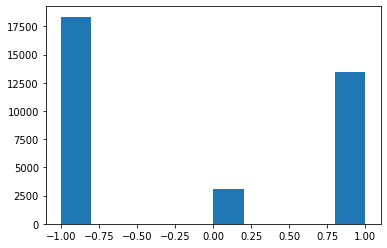

In [17]:
_ = plt.hist(df['sentiment'])

In [18]:
df.sort_values(by='sentiment_score', ascending=True)[:10]
neutral = df[df.sentiment_score < 0.6].index
df = df.drop(neutral)  # we want the model to learn from highly sentimental data
df.shape

(34045, 12)

In [19]:
# box plot of sentiment by topic

In [20]:
# plots of words (e.g. unigrams, bigrams, trigrams) of occurrences in positive/negative texts

In [21]:
# prepare to split the filtered csv
def train_test_split(df):
    # splits into a 80% train, 20% holdout test set
    mask = np.random.rand(len(df)) < 0.8
    train = df[mask]
    test = df[~mask]
    return train, test

In [22]:
# reduce columns before storing for annotation
df.drop(columns=['Unnamed: 0', 'score', 'score_within_variance', 'extractors', 'text_length'], inplace=True)

In [23]:
train, test = train_test_split(df)

In [24]:
train

,id,entity_id,name,text,sentiment,to_discard,sentiment_score
1,IjY5YWQ5MzE5YzA2ZTFhMTVkYjY2MDk5YjMyM2MyZGNhMT...,Q5469880,['Form 10-K'],"Other risks , uncertainties , and factors that...",-1,False,0.994886
2,IjY5YWQ5MzE5YzA2ZTFhMTVkYjY2MDk5YjMyM2MyZGNhMT...,Q1148747,['payment'],Examples of forward-looking statements in this...,-1,False,0.858857
3,IjY5YWQ5MzE5YzA2ZTFhMTVkYjY2MDk5YjMyM2MyZGNhMT...,Q1196314,['stock'],Ellington Financial Inc. -LRB- NYSE : EFC -RRB...,-1,False,0.973849
4,IjY5YWQ5MzE5YzA2ZTFhMTVkYjY2MDk5YjMyM2MyZGNhMT...,Q1196314,['stock'],The Company also announced its estimated book ...,-1,False,0.986583
5,IjY5YWQ5MzE5YzA2ZTFhMTVkYjY2MDk5YjMyM2MyZGNhMT...,Q1196314,['stock'],This estimate includes the effect of the previ...,-1,False,0.987645
...,...,...,...,...,...,...,...
50405,IjM0NWI4MmMzZTJlODZmOThlYzUwMGJiMjc1NDUzZTUyNW...,Q12125,['common cold'],That ’s really pretty important because most s...,1,False,0.994082
50407,IjM0NWI4MmMzZTJlODZmOThlYzUwMGJiMjc1NDUzZTUyNW...,Q2840,['influenza'],With the advent of the winter season and chang...,-1,False,0.992624
50409,IjM0NWI4MmMzZTJlODZmOThlYzUwMGJiMjc1NDUzZTUyNW...,Q2840,['influenza'],Despite concerns about growing bacterial resis...,-1,False,0.987625
50410,IjM0NWI4MmMzZTJlODZmOThlYzUwMGJiMjc1NDUzZTUyNW...,Q11000047,['health system'],"This is a crime against the science , the pati...",-1,False,0.996854


In [25]:
test

,id,entity_id,name,text,sentiment,to_discard,sentiment_score
6,IjY5YWQ5MzE5YzA2ZTFhMTVkYjY2MDk5YjMyM2MyZGNhMT...,Q1196314,['stock'],Estimated book value per $T$ is subject to cha...,-1,False,0.996859
13,ImEwODg5NDNhODE5MTdlMzAxODFmNWZmZDEzMjgwYzNkNG...,Q22656,['petroleum'],Sales tax on all $T$ products was brought up t...,-1,False,0.891785
23,ImEwODg5NDNhODE5MTdlMzAxODFmNWZmZDEzMjgwYzNkNG...,Q8161,['tax'],The FBR official said that if the government m...,-1,False,0.980065
31,ImEwODg5NDNhODE5MTdlMzAxODFmNWZmZDEzMjgwYzNkNG...,Q11055488,['sales tax'],The component of $T$ -LRB- 17 percent -RRB- in...,-1,False,0.983717
37,ImEwODg5NDNhODE5MTdlMzAxODFmNWZmZDEzMjgwYzNkNG...,Q8142,['currency'],Factors like $T$ depreciation would result in ...,-1,False,0.991218
...,...,...,...,...,...,...,...
50380,IjUxMTYzYWY3YWNjZmFmMjkwMzI5NmMzZmYxY2YzNThkM2...,Q2626074,['diffuse large B-cell lymphoma'],The study compares real-world response data of...,-1,False,0.958796
50386,IjUxMTYzYWY3YWNjZmFmMjkwMzI5NmMzZmYxY2YzNThkM2...,Q768501,['MorphoSys'],The study compares real-world response data of...,-1,False,0.880451
50395,IjUxMTYzYWY3YWNjZmFmMjkwMzI5NmMzZmYxY2YzNThkM2...,Q16978036,['EQS Group AG'],"30.12.2019 Dissemination of a Corporate News ,...",-1,False,0.991001
50406,IjM0NWI4MmMzZTJlODZmOThlYzUwMGJiMjc1NDUzZTUyNW...,Q12125,['common cold'],Parallel to that antibiotic has no impact on a...,-1,False,0.998950


In [26]:
# the DFs in the correct .xml.seg format, based around ACL14 and SemEval14
# TEXT
# TARGET
# SENTIMENT

def _write(f, data):
    f.write(data)
    f.write("\n")
    
def save_row(f, row):
    text = row['text']
    sentiment = str(row['sentiment'])
    target = eval(row['name'])[0]

    _write(f, text)
    _write(f, target)
    _write(f, sentiment)


In [27]:
save_train = os.path.join(os.getcwd(), "graphql-topic-downloads", "filtered", "train_neu.xml.seg")
with open(save_train, 'w', encoding="utf8") as f:
    [save_row(f, row) for idx, row in train.iterrows()]

In [28]:
save_test = os.path.join(os.getcwd(), "graphql-topic-downloads", "filtered", "test_neu.xml.seg")
with open(save_test, 'w', encoding="utf8") as f:
    [save_row(f, row) for idx, row in test.iterrows()]